In [131]:
import pandas as pd
import numpy as np
import os

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## Read bin predictions

In [132]:
pred= {}
for i in range(2,13):
    pred[i] = pd.read_csv(os.path.join('data',f'data_for_planner_inc_{i}.csv'), index_col=0)

In [133]:
pred[2].head()

,id,cluster,day,num_increments,pred_date,real_date,interval_for_planner,max_hour,success
0,0,1,30/01/2021,2,2021-01-30 23:55:41,2021-01-30 23:55:55,"(22, 23)",23,NaN
1,1,1,30/01/2021,2,2021-01-30 19:37:05,2021-01-30 21:26:03,"(18, 19)",21,NaN
2,3,1,29/01/2021,2,2021-01-29 21:07:15,2021-01-29 22:50:30,"(20, 21)",22,NaN
3,6,1,29/01/2021,2,2021-01-29 19:22:59,2021-01-29 20:28:27,"(18, 19)",20,NaN
4,7,1,29/01/2021,2,2021-01-29 19:22:59,2021-01-29 20:28:27,"(18, 19)",20,NaN


In [134]:
pred[2][pred[2]['day']=='12/01/2021']

,id,cluster,day,num_increments,pred_date,real_date,interval_for_planner,max_hour,success
70,111,0,12/01/2021,2,2021-01-12 23:07:15,2021-01-12 23:17:37,"(22, 23)",23,NaN
71,112,1,12/01/2021,2,2021-01-13 00:30:39,2021-01-12 23:40:00,"(23, 24)",23,NaN
72,114,0,12/01/2021,2,2021-01-12 19:50:38,2021-01-12 22:25:03,"(18, 19)",22,NaN
73,116,0,12/01/2021,2,2021-01-12 19:55:57,2021-01-12 19:46:07,"(18, 19)",19,NaN
74,117,1,12/01/2021,2,2021-01-12 15:45:35,2021-01-12 19:03:27,"(14, 15)",19,NaN
75,118,1,12/01/2021,2,2021-01-13 15:26:46,2021-01-12 17:39:13,"(14, 15)",17,NaN
76,119,0,12/01/2021,2,2021-01-12 12:51:29,2021-01-12 15:35:50,"(11, 12)",15,NaN
77,120,1,12/01/2021,2,2021-01-12 14:22:02,2021-01-12 14:58:15,"(13, 14)",14,NaN
78,121,2,12/01/2021,2,2021-01-12 00:34:45,2021-01-12 02:42:16,"(23, 24)",2,NaN
79,122,1,12/01/2021,2,2021-01-11 23:50:42,2021-01-12 02:05:39,"(22, 23)",2,NaN


## Read time matrices

In [135]:
location_cluster ={0:[1,2,3], 1:[4,5,6], 2:[7,8]}
#location_cluster = [0, 0, 0, 1, 1, 1, 2, 2] # association location and cluster

In [136]:
def round_time(x):
    h=0
    if ":" in x:
        parts = x.split(':')
        h = int(parts[0])
        m = int(parts[1])
        if m >= 30:
            h += 1
    return h

In [137]:
t_mtx_foot= pd.read_csv(os.path.join('data','Matrix with Waste Pickers OnFoot.csv'), index_col=0)
t_mtx_foot = t_mtx_foot.fillna('0')
t_mtx_foot_rounded=t_mtx_foot.applymap(round_time)

In [138]:
t_mtx_foot.head()

,WP1,WP2,1,2,3,4,5,6,7,8
WP1,0,2:43:00,0:06:00,0:06:00,0:06:00,2:57:00,3:06:00,2:48:00,0:35:00,0:49:00
WP2,2:43:00,0,2:39:00,2:43:00,2:40:00,0:17:00,0:25:00,0:09:00,2:19:00,1:14:00
1,0:06:00,2:39:00,0,0:08:00,0:02:00,2:59:00,3:08:00,2:50:00,0:40:00,0:54:00
2,0:06:00,2:43:00,0:08:00,0,0:07:00,3:04:00,3:12:00,2:54:00,0:41:00,1:02:00
3,0:06:00,2:40:00,0:02:00,0:07:00,0,3:00:00,3:10:00,2:51:00,0:40:00,0:52:00


In [139]:
t_mtx_foot_rounded

,WP1,WP2,1,2,3,4,5,6,7,8
WP1,0,3,0,0,0,3,3,3,1,1
WP2,3,0,3,3,3,0,0,0,2,1
1,0,3,0,0,0,3,3,3,1,1
2,0,3,0,0,0,3,3,3,1,1
3,0,3,0,0,0,3,3,3,1,1
4,3,0,3,3,3,0,0,0,3,2
5,3,0,3,3,3,0,0,0,3,3
6,3,0,3,3,3,0,0,0,2,2
7,1,2,1,1,1,3,3,2,0,0
8,1,1,1,1,1,2,3,2,0,0


In [140]:
t_mtx_car= pd.read_csv(os.path.join('data','Matrix with Waste Pickers ByCar.csv'), index_col=0)
t_mtx_car = t_mtx_car.fillna('0')
t_mtx_car_rounded=t_mtx_car.applymap(round_time)
t_mtx_car_rounded

,WP1,WP2,1,2,3,4,5,6,7,8
WP1,0,0,0,0,0,0,0,0,0,0
WP2,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,1,1,0,0
3,0,0,0,0,0,1,1,0,0,0
4,0,0,1,1,1,0,0,0,1,1
5,0,0,0,1,1,0,0,0,1,1
6,0,0,0,1,0,0,0,0,1,1
7,0,0,0,0,0,1,1,1,0,0
8,0,0,0,0,0,1,1,1,0,0


In [141]:
t_mtx_bike= pd.read_csv(os.path.join('data','Matrix with Waste Pickers ByBike.csv'), index_col=0)
t_mtx_bike = t_mtx_bike.fillna('0')
t_mtx_bike_rounded=t_mtx_bike.applymap(round_time)
t_mtx_bike_rounded

,WP1,WP2,1,2,3,4,5,6,7,8
WP1,0,1,0,0,0,1,1,1,0,0
WP2,1,0,1,1,1,0,0,0,1,2
1,0,1,0,0,0,2,2,2,0,0
2,0,1,0,0,0,1,1,1,0,0
3,0,1,0,0,0,1,1,1,0,0
4,1,0,2,1,1,0,0,0,1,1
5,1,0,2,1,1,0,0,0,1,1
6,1,0,2,1,1,0,0,0,1,1
7,0,1,0,0,0,1,1,1,0,0
8,0,2,0,0,0,1,1,1,0,0


In [142]:
t_mtx_bike_rounded.values

array([[0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
       [1, 0, 1, 1, 1, 0, 0, 0, 1, 2],
       [0, 1, 0, 0, 0, 2, 2, 2, 0, 0],
       [0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
       [1, 0, 2, 1, 1, 0, 0, 0, 1, 1],
       [1, 0, 2, 1, 1, 0, 0, 0, 1, 1],
       [1, 0, 2, 1, 1, 0, 0, 0, 1, 1],
       [0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 2, 0, 0, 0, 1, 1, 1, 0, 0]], dtype=int64)

In [143]:
time_matrices={'foot':t_mtx_foot_rounded,
             'car':t_mtx_car_rounded,
             'bike':t_mtx_bike_rounded}

In [144]:
mtx= t_mtx_bike_rounded
predictions = pred[2]
d= '30/01/2021'

time_windows = [(0,5),(0,5)]
time_matrix = []

p_=  predictions[predictions['day']==d]
indexes =['WP1','WP2']
for c in range(0,3):
    p_c = p_[p_['cluster']==c]
    #print(p_c)
    if not p_c.empty:
        j=0
        locs_for_cluster = location_cluster[c]
        for i,v in p_c.iterrows():
            range_= v['interval_for_planner']
            #print(range_,locs_for_cluster[j])
            time_windows.append(range_)
            indexes.append(str(locs_for_cluster[j]))
            j += 1
            if j== len(locs_for_cluster):
                break
print(indexes)
time_matrix= mtx.loc[indexes,indexes].values
time_windows, time_matrix

['WP1', 'WP2', '4', '5']


([(0, 5), (0, 5), '(22, 23)', '(18, 19)'],
 array([[0, 1, 1, 1],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]], dtype=int64))

In [145]:
def generate_time_windows_fn(d, predictions, location_cluster, mtx, waste_picker_code):
    
    experiments = {}
    
    time_windows = [(0,5)]
    time_matrix = []

    p_=  predictions[predictions['day']==d]
    indexes =[waste_picker_code]
    nelements =1
    for c in range(0,3):
        p_c = p_[p_['cluster']==c]
        if not p_c.empty:
            j=0
            locs_for_cluster = location_cluster[c]
            for i,v in p_c.iterrows():
                range_= v['interval_for_planner']
                time_windows.append(eval(range_))
                indexes.append(str(locs_for_cluster[j]))
                experiments[nelements] =i
                j += 1
                nelements +=1
                if j== len(locs_for_cluster):
                    break
    time_matrix= mtx.loc[indexes,indexes].values
    return time_windows, time_matrix, experiments

In [146]:
tw,tm,ex= generate_time_windows_fn('14/01/2021', pred[2], location_cluster, t_mtx_bike_rounded, 'WP1')

In [147]:
tw,tm,ex

([(0, 5),
  (20, 21),
  (20, 21),
  (19, 20),
  (22, 23),
  (23, 24),
  (20, 21),
  (17, 18)],
 array([[0, 0, 0, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 2, 2, 2, 0],
        [0, 0, 0, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 1, 1, 1, 0],
        [1, 2, 1, 1, 0, 0, 0, 1],
        [1, 2, 1, 1, 0, 0, 0, 1],
        [1, 2, 1, 1, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 1, 1, 0]], dtype=int64),
 {1: 48, 2: 51, 3: 52, 4: 49, 5: 50, 6: 53, 7: 57})

In [148]:
def create_model_fn(d, pred_, loc_cluster_, mtx_,wpc):
    data = {}
    
    tw,tm, ex= generate_time_windows_fn(d, pred_, loc_cluster_, mtx_,wpc)
    data['time_matrix'] =tm
    data['time_windows'] = tw
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data, ex

In [149]:
def print_solution(data, manager, routing, solution, show=True):
    solution_= {}
    """Prints solution on console."""
    if show:
        print(f'Objective: {solution.ObjectiveValue()}')
    time_dimension = routing.GetDimensionOrDie('Time')
    total_time = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        while not routing.IsEnd(index):
            time_var = time_dimension.CumulVar(index)
            plan_output += '{0} Time({1},{2}) -> '.format(
                manager.IndexToNode(index), solution.Min(time_var),
                solution.Max(time_var))
            solution_[manager.IndexToNode(index)]= (solution.Min(time_var),solution.Max(time_var))
            index = solution.Value(routing.NextVar(index))
        time_var = time_dimension.CumulVar(index)
        plan_output += '{0} Time({1},{2})\n'.format(manager.IndexToNode(index),
                                                    solution.Min(time_var),
                                                    solution.Max(time_var))
        
        plan_output += 'Time of the route: {}min\n'.format(
            solution.Min(time_var))
        if show:
            print(plan_output)
        total_time += solution.Min(time_var)
    if show:
        print('Total time of all routes: {}min'.format(total_time))
    return solution_

In [150]:
def simulate_route_for_waste_picker(data, time_mtx):#, predictions, day, waste_picker_code):

    """Solve the VRP with time windows."""
    # Instantiate the data problem.
    #data, ex = create_model_fn(day, p, location_cluster, mtx, waste_picker_code)
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['time_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def time_callback(from_index, to_index):   
        """Returns the travel time between the two nodes."""

        # Convert from routing variable Index to time matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['time_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(time_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Time Windows constraint.
    time = 'Time'
    routing.AddDimension(
        transit_callback_index,
        30,  # allow waiting time
        30,  # maximum time per vehicle
        False,  # Don't force start cumul to zero.
        time)

    time_dimension = routing.GetDimensionOrDie(time)
    # Add time window constraints for each location except depot.
    for location_idx, time_window in enumerate(data['time_windows']):
        if location_idx == data['depot']:
            continue
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
    # Add time window constraints for each vehicle start node.
    depot_idx = data['depot']
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        time_dimension.CumulVar(index).SetRange(
            data['time_windows'][depot_idx][0],
            data['time_windows'][depot_idx][1])

    # Instantiate route start and end times to produce feasible times.
    for i in range(data['num_vehicles']):
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.Start(i)))
        routing.AddVariableMinimizedByFinalizer(
            time_dimension.CumulVar(routing.End(i)))

    #Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    sol_ = None
    # Print solution on console.
    if solution:
        sol_=print_solution(data, manager, routing, solution, show=False)
        print(sol_,data['time_windows'])
        
    return sol_

In [151]:
def calculate_collection_rate_fn(predictions, route, experiment):
    #print(predictions, route, experiment)
    #print(predictions, route)
    if bool(route):
        for i,j in experiment.items():
            real_tw = route[i]
            max_h = predictions.loc[j]['max_hour']
            if real_tw[1]<=max_h:
                #print('ok')
                predictions.loc[j,'success']=True
            else:
                #print("fail")
                predictions.loc[j,'success']=False

        predictions_eval= predictions.dropna()
        rate = predictions_eval[predictions_eval['success']==True].shape[0]/predictions_eval.shape[0]
        #print(day, rate)
        return rate
    else:
        return 0

In [152]:
def simulate_route(time_mtx, predictions, day, waste_picker_codes):
    waste_pickers_route = {}

    for c in waste_picker_codes:
        data, ex = create_model_fn(day, p, location_cluster, time_mtx, c)
        route= simulate_route_for_waste_picker(data, time_mtx)#, predictions, day, c)
        if route is not None:
            for loc, tw in route.items():
                if loc != 0:
                    curr_tw = waste_pickers_route.get(loc,(float('inf'),float('inf')))
                    if tw[1] < curr_tw[1]:
                        waste_pickers_route[loc]=tw                    
    rate = calculate_collection_rate_fn(p, waste_pickers_route, ex)
    return waste_pickers_route, rate

In [162]:
all_results = {}
day_results = {}
for i in range(2,13):
    p = pred[i] 
    for transport, mtx  in time_matrices.items():
        print(f"{transport}----------------------------------")
        transp_results = all_results.get(transport,[])
        transp_results_day = day_results.get(transport,[])
        day_rates = []
        for day in p['day'].unique():
            waste_pickers_sols = {}
            route, rate= simulate_route(mtx, p, day, ['WP1', 'WP2'])
            #print(i, transport, day, route, rate)
            day_rates.append(rate)
            transp_results_day.append((day,rate))
        
        transp_results.append(sum(day_rates)/len(day_rates))
        all_results[transport]= transp_results
        day_results[transport]= transp_results_day
        

foot----------------------------------
{0: (0, 0), 2: (18, 19), 1: (22, 22)} [(0, 5), (22, 23), (18, 19)]
{0: (0, 0), 2: (18, 19), 1: (22, 22)} [(0, 5), (22, 23), (18, 19)]
{0: (0, 0), 3: (18, 19), 2: (18, 19), 1: (20, 20)} [(0, 5), (20, 21), (18, 19), (18, 19)]
{0: (0, 0), 3: (18, 19), 2: (18, 19), 1: (20, 20)} [(0, 5), (20, 21), (18, 19), (18, 19)]
{0: (0, 0), 3: (16, 17), 2: (17, 18), 1: (18, 19), 6: (21, 22), 5: (22, 22), 4: (22, 22)} [(0, 5), (18, 19), (17, 18), (16, 17), (21, 22), (22, 23), (21, 22)]
{0: (0, 0), 3: (16, 17), 2: (17, 18), 1: (18, 19), 6: (21, 22), 5: (22, 22), 4: (22, 22)} [(0, 5), (18, 19), (17, 18), (16, 17), (21, 22), (22, 23), (21, 22)]
{0: (0, 0), 1: (18, 18)} [(0, 5), (18, 19)]
{0: (0, 0), 1: (18, 18)} [(0, 5), (18, 19)]
{0: (0, 0), 1: (18, 18)} [(0, 5), (18, 19)]
{0: (0, 0), 1: (18, 18)} [(0, 5), (18, 19)]
{0: (0, 0), 3: (0, 1), 1: (3, 4), 4: (21, 21), 2: (24, 24)} [(0, 5), (3, 4), (23, 24), (0, 1), (21, 22)]
{0: (0, 0), 2: (20, 20), 1: (20, 20)} [(0, 5), (

{0: (0, 0), 4: (1, 2), 5: (16, 16), 3: (17, 17), 2: (17, 18), 6: (22, 22), 1: (22, 22)} [(0, 5), (22, 23), (17, 18), (16, 17), (1, 2), (16, 17), (22, 23)]
{0: (0, 0), 6: (14, 15), 5: (14, 15), 3: (18, 19), 2: (18, 19), 1: (22, 23), 7: (23, 23), 4: (24, 24)} [(0, 5), (22, 23), (18, 19), (18, 19), (23, 24), (14, 15), (14, 15), (23, 24)]
{0: (0, 0), 6: (14, 15), 5: (14, 15), 3: (18, 19), 2: (18, 19), 1: (22, 23), 7: (23, 23), 4: (24, 24)} [(0, 5), (22, 23), (18, 19), (18, 19), (23, 24), (14, 15), (14, 15), (23, 24)]
{0: (0, 0), 2: (1, 2), 6: (17, 17), 7: (18, 18), 1: (18, 18), 5: (20, 20), 4: (20, 20), 3: (21, 21)} [(0, 5), (18, 19), (1, 2), (21, 22), (20, 21), (19, 20), (17, 18), (18, 19)]
{0: (0, 0), 2: (1, 2), 6: (17, 17), 7: (18, 18), 1: (18, 18), 5: (20, 20), 4: (20, 20), 3: (21, 21)} [(0, 5), (18, 19), (1, 2), (21, 22), (20, 21), (19, 20), (17, 18), (18, 19)]
{0: (0, 0), 2: (2, 3), 3: (17, 18), 1: (19, 20), 4: (22, 22)} [(0, 5), (19, 20), (2, 3), (17, 18), (22, 23)]
{0: (0, 0), 2: (

{0: (0, 0), 1: (19, 19)} [(0, 5), (19, 20)]
{0: (0, 0), 1: (19, 19)} [(0, 5), (19, 20)]
{0: (0, 0), 1: (20, 20)} [(0, 5), (20, 21)]
{0: (0, 0), 1: (20, 20)} [(0, 5), (20, 21)]
{0: (0, 0), 1: (17, 17)} [(0, 5), (17, 18)]
{0: (0, 0), 1: (17, 17)} [(0, 5), (17, 18)]
bike----------------------------------
{0: (0, 0), 2: (18, 19), 1: (22, 22)} [(0, 5), (22, 23), (18, 19)]
{0: (0, 0), 2: (18, 19), 1: (22, 22)} [(0, 5), (22, 23), (18, 19)]
{0: (0, 0), 3: (19, 20), 2: (19, 20), 1: (22, 22)} [(0, 5), (22, 23), (19, 20), (19, 20)]
{0: (0, 0), 3: (19, 20), 2: (19, 20), 1: (22, 22)} [(0, 5), (22, 23), (19, 20), (19, 20)]
{0: (0, 0), 3: (16, 17), 2: (17, 18), 1: (19, 20), 6: (22, 22), 5: (22, 22), 4: (22, 22)} [(0, 5), (19, 20), (17, 18), (16, 17), (21, 22), (22, 23), (22, 23)]
{0: (0, 0), 3: (16, 17), 2: (17, 18), 1: (19, 20), 6: (22, 22), 5: (22, 22), 4: (22, 22)} [(0, 5), (19, 20), (17, 18), (16, 17), (21, 22), (22, 23), (22, 23)]
{0: (0, 0), 1: (20, 20)} [(0, 5), (20, 21)]
{0: (0, 0), 1: (20, 2

{0: (0, 0), 4: (5, 6), 3: (5, 6), 2: (17, 18), 1: (21, 22), 5: (23, 23)} [(0, 5), (21, 22), (17, 18), (5, 6), (5, 6), (23, 24)]
{0: (0, 0), 4: (5, 6), 3: (5, 6), 2: (17, 18), 1: (21, 22), 5: (23, 23)} [(0, 5), (21, 22), (17, 18), (5, 6), (5, 6), (23, 24)]
{0: (0, 0), 3: (16, 17), 1: (19, 20), 2: (21, 21)} [(0, 5), (19, 20), (21, 22), (16, 17)]
{0: (0, 0), 3: (16, 17), 1: (19, 20), 2: (21, 21)} [(0, 5), (19, 20), (21, 22), (16, 17)]
{0: (0, 0), 2: (22, 22), 1: (22, 22)} [(0, 5), (22, 23), (22, 23)]
{0: (0, 0), 2: (22, 22), 1: (22, 22)} [(0, 5), (22, 23), (22, 23)]
{0: (0, 0), 1: (19, 19)} [(0, 5), (19, 20)]
{0: (0, 0), 1: (19, 19)} [(0, 5), (19, 20)]
{0: (0, 0), 2: (18, 18), 1: (19, 19)} [(0, 5), (19, 20), (18, 19)]
{0: (0, 0), 2: (18, 18), 1: (19, 19)} [(0, 5), (19, 20), (18, 19)]
{0: (0, 0), 1: (18, 19), 2: (20, 20)} [(0, 5), (18, 19), (20, 21)]
{0: (0, 0), 1: (18, 19), 2: (20, 20)} [(0, 5), (18, 19), (20, 21)]
{0: (0, 0), 6: (17, 18), 3: (21, 21), 1: (21, 21), 5: (21, 21), 2: (22, 22

{0: (0, 0), 3: (0, 1), 2: (0, 1), 1: (13, 13)} [(0, 5), (13, 14), (0, 1), (0, 1)]
{0: (0, 0), 3: (0, 1), 2: (0, 1), 1: (13, 13)} [(0, 5), (13, 14), (0, 1), (0, 1)]
{0: (0, 0), 1: (1, 2), 2: (19, 19)} [(0, 5), (1, 2), (19, 20)]
{0: (0, 0), 1: (1, 2), 2: (19, 19)} [(0, 5), (1, 2), (19, 20)]
{0: (0, 0), 1: (4, 4)} [(0, 5), (4, 5)]
{0: (0, 0), 1: (4, 4)} [(0, 5), (4, 5)]
{0: (0, 0), 2: (21, 21), 1: (21, 21)} [(0, 5), (20, 21), (21, 22)]
{0: (0, 0), 2: (21, 21), 1: (21, 21)} [(0, 5), (20, 21), (21, 22)]
{0: (0, 0), 3: (0, 1), 2: (18, 19), 1: (21, 21)} [(0, 5), (21, 22), (18, 19), (0, 1)]
{0: (0, 0), 3: (0, 1), 2: (18, 19), 1: (21, 21)} [(0, 5), (21, 22), (18, 19), (0, 1)]
{0: (0, 0), 1: (14, 14)} [(0, 5), (14, 15)]
{0: (0, 0), 1: (14, 14)} [(0, 5), (14, 15)]
{0: (0, 0), 1: (20, 20)} [(0, 5), (20, 21)]
{0: (0, 0), 1: (20, 20)} [(0, 5), (20, 21)]
{0: (0, 0), 1: (20, 20)} [(0, 5), (20, 21)]
{0: (0, 0), 1: (20, 20)} [(0, 5), (20, 21)]
{0: (0, 0), 1: (18, 18)} [(0, 5), (18, 19)]
{0: (0, 0), 1: (

### Results based on means of transport

In [154]:
all_results_df = pd.DataFrame.from_dict(all_results)
all_results_df.index=range(2,13)

In [155]:
all_results_df

,foot,car,bike
2,0.479925,0.707675,0.720565
3,0.488765,0.750088,0.760204
4,0.682873,0.776997,0.803350
5,0.830918,0.883478,0.859788
6,0.901037,0.866667,0.866667
7,0.655556,0.666667,0.666667
8,1.000000,1.000000,1.000000
9,1.000000,1.000000,1.000000
10,1.000000,1.000000,1.000000
11,1.000000,1.000000,1.000000


In [156]:
all_results_df.loc['Avg.']= all_results_df.mean(axis=0)

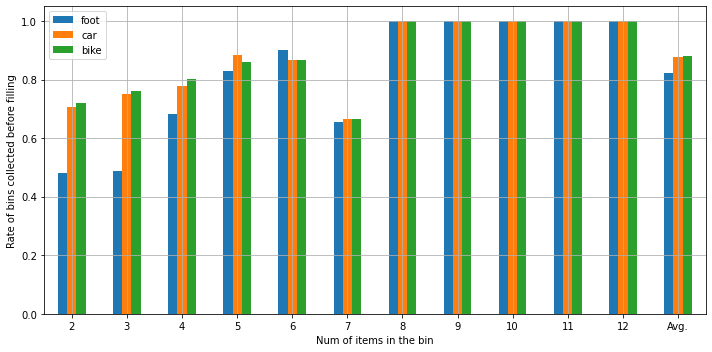

In [157]:
ax=all_results_df.plot(kind='bar', grid=True, figsize=(10,5), rot=0);
ax.set_xlabel("Num of items in the bin");
ax.set_ylabel("Rate of bins collected before filling");
plt.tight_layout()
plt.savefig(os.path.join('figs','collection_rate_per_transport.png'))

### Results per day

In [158]:
day_results_df={}
for k, data in day_results.items():
    day_results_df[k] = pd.DataFrame.from_records(data, columns=f'day {k}'.split())
    day_results_df[k]= day_results_df[k].set_index('day')


In [159]:
df= day_results_df['foot']
df['car']= day_results_df['car']['car']
df['bike']= day_results_df['bike']['bike']
df.head()

,foot,car,bike
day,,,
30/01/2021,1.000000,0.644444,0.747253
29/01/2021,1.000000,0.644444,0.747253
28/01/2021,0.727273,0.644444,0.747253
27/01/2021,0.750000,0.644444,0.747253
26/01/2021,0.692308,0.644444,0.747253


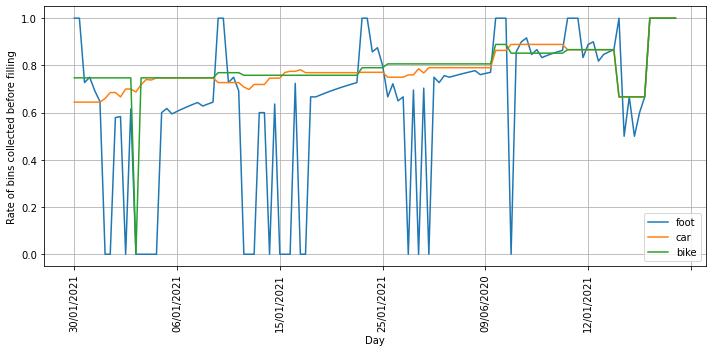

In [160]:
ax=df.plot(grid=True, rot=90, figsize=(10,5));
ax.set_xlabel('Day');
ax.set_ylabel("Rate of bins collected before filling");
plt.tight_layout()
plt.savefig(os.path.join('figs','collection_rate_evol.png'))

In [161]:
print("That's all folks")

That's all folks
